### In this notebook I predict whether a financial transaction was fraudulent or not, using a LightGBM model. 

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Explaination of the data:

The data is from Kaggle:

https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset/code?datasetId=2093649&sortBy=voteCount

    step: represents a unit of time where 1 step equals 1 hour
    type: type of online transaction
    amount: the amount of the transaction
    nameOrig: customer starting the transaction
    oldbalanceOrg: balance before the transaction
    newbalanceOrig: balance after the transaction
    nameDest: recipient of the transaction
    oldbalanceDest: initial balance of recipient before the transaction
    newbalanceDest: the new balance of recipient after the transaction
    isFraud: fraud transaction


In [32]:
# Financial Fraud Detection\Data\data.csv
df = pd.read_csv('./Data/data.csv')


In [12]:
# Check for NaNs
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [26]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


# Transform object type data into numeric type data

In [34]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:")
print(categorical_columns)


Categorical Columns:
['type', 'nameOrig', 'nameDest']


In [35]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for col in categorical_columns:
    if col in df.columns:  # Ensuring the column exists in X dataframe
        df[col] = label_encoder.fit_transform(df[col])

# Now proceed to train the model using LightGBM as described previously


# Feature engineering

construct the following features:

nameOrig frequency
nameDest frequency

In [ ]:
# Assuming df is your dataframe with columns ['type', 'nameOrig', 'nameDest']

# For 'type' column
#type_frequency = df['type'].value_counts()
#df['type_frequency'] = df['type'].map(type_frequency)
#
## For 'nameOrig' column
#nameOrig_frequency = df['nameOrig'].value_counts()
#df['nameOrig_frequency'] = df['nameOrig'].map(nameOrig_frequency)
#
## For 'nameDest' column
#nameDest_frequency = df['nameDest'].value_counts()
#df['nameDest_frequency'] = df['nameDest'].map(nameDest_frequency)
#
## Display the modified dataframe
#print(df)


In [36]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Categorize [type, nameOrig, nameDest]

In [37]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',  # For binary classification
    'metric': 'binary_error',  # Evaluation metric
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}
num_round = 30

In [38]:
model = lgb.train(params, train_set=lgb.Dataset(X_train, label=y_train), num_boost_round=num_round)
# Add early stopping

y_pred = model.predict(X_test, num_iteration=model.best_iteration)


In [39]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
threshold = 0.5  # Adjust this threshold based on your preference and problem requirements
binary_predictions = [1 if pred > threshold else 0 for pred in y_pred]

accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9994
Precision: 0.7696
Recall: 0.7855
F1 Score: 0.7774


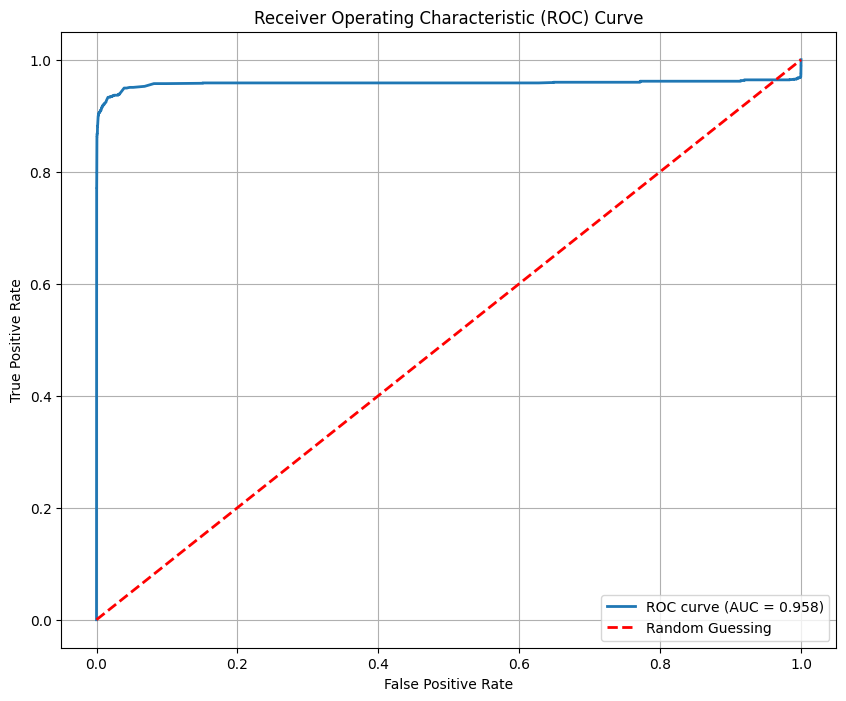

In [57]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.plot(fpr, tpr, lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')
ax.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate', title = 'Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc='lower right')
ax.grid(True)